In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import sys

SRC = Path("__file__").resolve().parents[1]
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import config as cfg

In [84]:
# Load the traffic data
df = pd.read_csv(cfg.RAW_TRF / "dft_rawcount_region_id_6.csv")

# Create timestamp
df["timestamp"] = pd.to_datetime(df["count_date"]) + pd.to_timedelta(df["hour"], unit="h")

# Confirm datetime
print("=== OVERVIEW ===")
print(f"rows                     : {len(df):,}")
print(f"first_timestamp          : {df['timestamp'].min()}")
print(f"last_timestamp           : {df['timestamp'].max()}")
print(f"unique count_point_id    : {df['count_point_id'].nunique()}")
print(f"% NaN in all_motor_vehicles : {df['all_motor_vehicles'].isna().mean() * 100:.2f}")

C:\Users\clown\AppData\Local\Temp\ipykernel_23672\3471057864.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cfg.RAW_TRF / "dft_rawcount_region_id_6.csv")


=== OVERVIEW ===
rows                     : 403,560
first_timestamp          : 2000-03-17 07:00:00
last_timestamp           : 2023-11-07 18:00:00
unique count_point_id    : 3349
% NaN in all_motor_vehicles : 0.00


In [91]:
# Per-site Coverage
site_summary = (
    df.groupby("count_point_id")
    .agg(
        rows=("all_motor_vehicles", "size"),
        first=("timestamp", "min"),
        last=("timestamp", "max"),
        nan_pct=("all_motor_vehicles", lambda x: x.isna().mean() * 100),
    )
    .sort_values("nan_pct", ascending=False)
)

print("\n=== PER-SITE COVERAGE === (top 20 by % NaN)")
print(site_summary.head(20))


=== PER-SITE COVERAGE === (top 20 by % NaN)
                rows               first                last   nan_pct
count_point_id                                                        
27660            120 2003-05-16 07:00:00 2021-09-06 18:00:00  0.833333
6000             192 2000-03-27 07:00:00 2016-05-05 18:00:00  0.000000
811225            24 2019-05-13 07:00:00 2019-05-13 18:00:00  0.000000
811213            96 2019-05-20 07:00:00 2023-05-15 18:00:00  0.000000
811214           120 2019-05-03 07:00:00 2023-04-28 18:00:00  0.000000
811215           120 2019-05-10 07:00:00 2023-04-28 18:00:00  0.000000
811216            24 2019-06-13 07:00:00 2019-06-13 18:00:00  0.000000
811218            24 2019-07-02 07:00:00 2019-07-02 18:00:00  0.000000
811219            24 2019-06-27 07:00:00 2019-06-27 18:00:00  0.000000
811220           120 2019-10-03 07:00:00 2023-09-28 18:00:00  0.000000
811221            96 2019-07-10 07:00:00 2023-07-12 18:00:00  0.000000
811222           120 2019-05-16 

In [95]:
# NaN by Month
df["month"] = df["timestamp"].dt.to_period("M").astype(str)
monthly_nan = df.groupby("month")["all_motor_vehicles"].apply(lambda x: x.isna().mean() * 100)
print("\n=== % NaN by month ===")
print(monthly_nan)


=== % NaN by month ===
month
2000-03    0.0
2000-04    0.0
2000-05    0.0
2000-06    0.0
2000-07    0.0
          ... 
2023-06    0.0
2023-07    0.0
2023-09    0.0
2023-10    0.0
2023-11    0.0
Name: all_motor_vehicles, Length: 176, dtype: float64


In [97]:
# === 4. Hour × Day-of-Week Availability Matrix ===
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek
heatmap_data = (
    df.groupby(["dow", "hour"])["all_motor_vehicles"]
    .apply(lambda x: 1.0 if x.notna().all() else 0.0)
    .unstack(fill_value=0)
)
print("\n=== Hour × Day-of-Week availability (1 = no NaN) ===")
print(heatmap_data)


=== Hour × Day-of-Week availability (1 = no NaN) ===
hour   7    8    9    10   11   12   13   14   15   16   17   18
dow                                                             
0     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2     0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0


In [99]:
# === 5. Site with highest % missing ===
worst_site = site_summary.head(1)
print("\n=== Site with highest % missing ===")
print(worst_site.T)



=== Site with highest % missing ===
count_point_id                27660
rows                            120
first           2003-05-16 07:00:00
last            2021-09-06 18:00:00
nan_pct                    0.833333


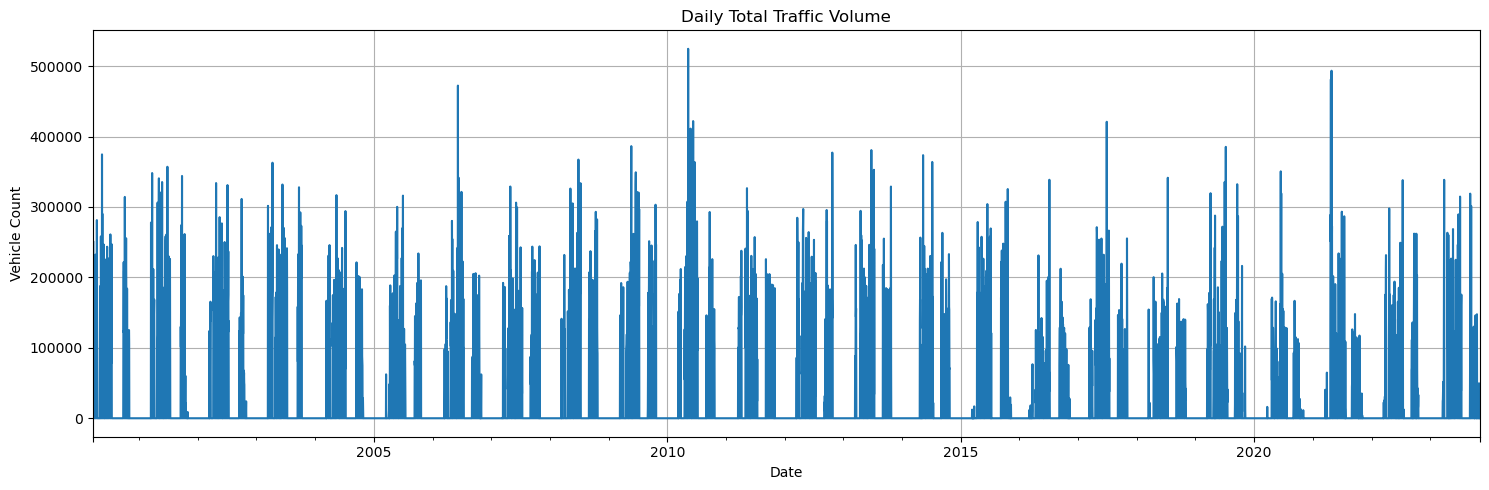

In [101]:
# Ensure timestamp column exists
df['timestamp'] = pd.to_datetime(df['count_date']) + pd.to_timedelta(df['hour'], unit='h')

daily_traffic = df.resample('D', on='timestamp')['all_motor_vehicles'].sum()

plt.figure(figsize=(15, 5))
daily_traffic.plot()
plt.title("Daily Total Traffic Volume")
plt.ylabel("Vehicle Count")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


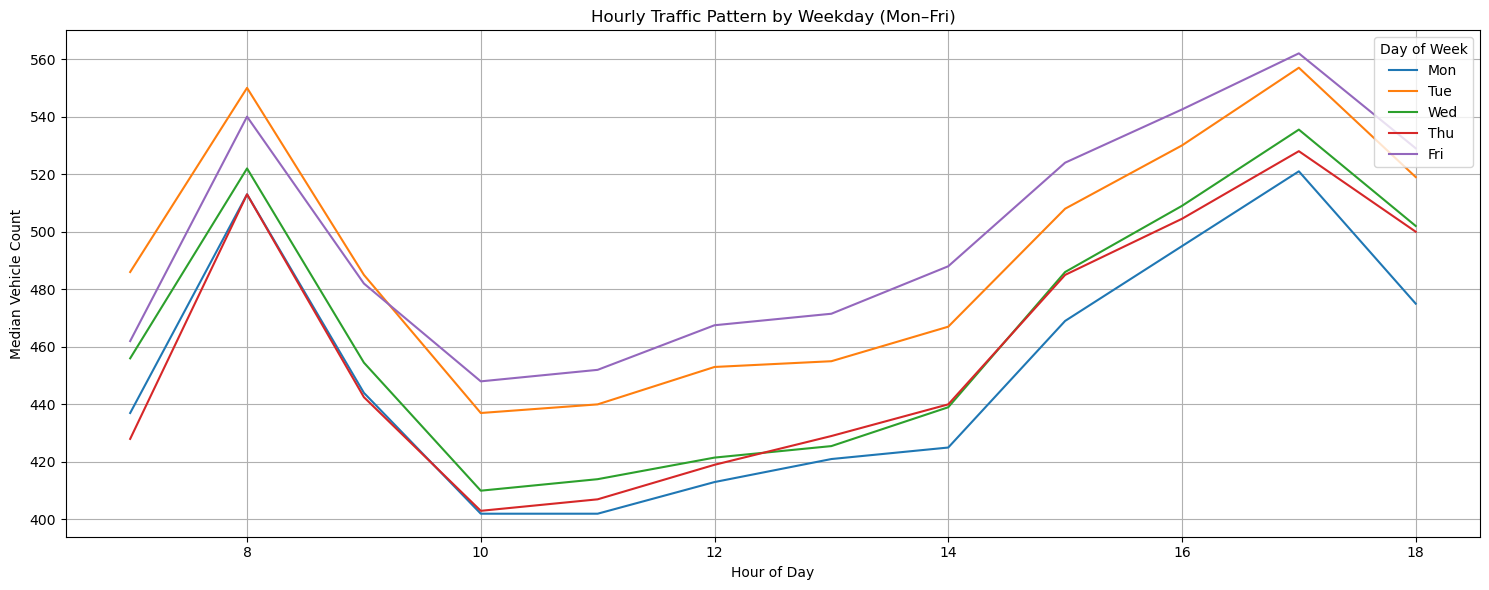

In [105]:
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek  # 0 = Monday

plt.figure(figsize=(15, 6))
sns.lineplot(
    data=df,
    x="hour",
    y="all_motor_vehicles",
    hue="dow",
    estimator="median",
    palette="tab10",
    errorbar=None
)
plt.title("Hourly Traffic Pattern by Weekday (Mon–Fri)")
plt.ylabel("Median Vehicle Count")
plt.xlabel("Hour of Day")
plt.legend(
    title="Day of Week", 
    labels=["Mon", "Tue", "Wed", "Thu", "Fri"], 
    loc="upper right"
)
plt.grid(True)
plt.tight_layout()
plt.show()


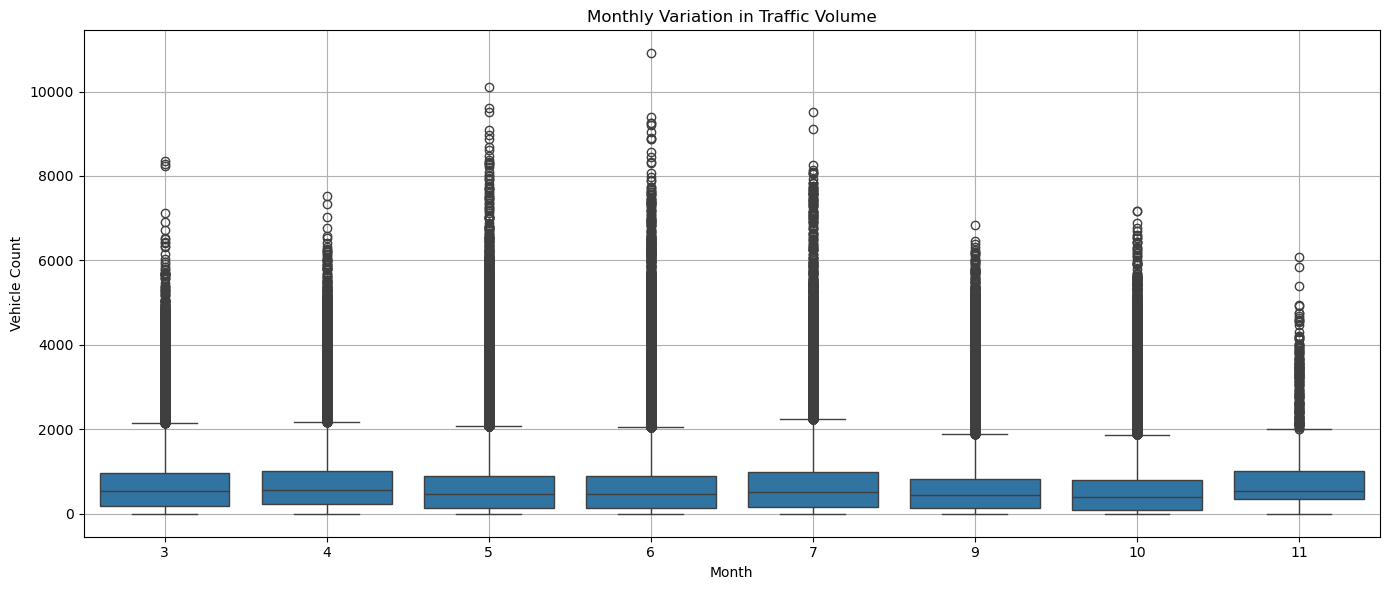

In [107]:
df["month"] = df["timestamp"].dt.month
df["year"] = df["timestamp"].dt.year

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="month", y="all_motor_vehicles")
plt.title("Monthly Variation in Traffic Volume")
plt.xlabel("Month")
plt.ylabel("Vehicle Count")
plt.grid(True)
plt.tight_layout()
plt.show()


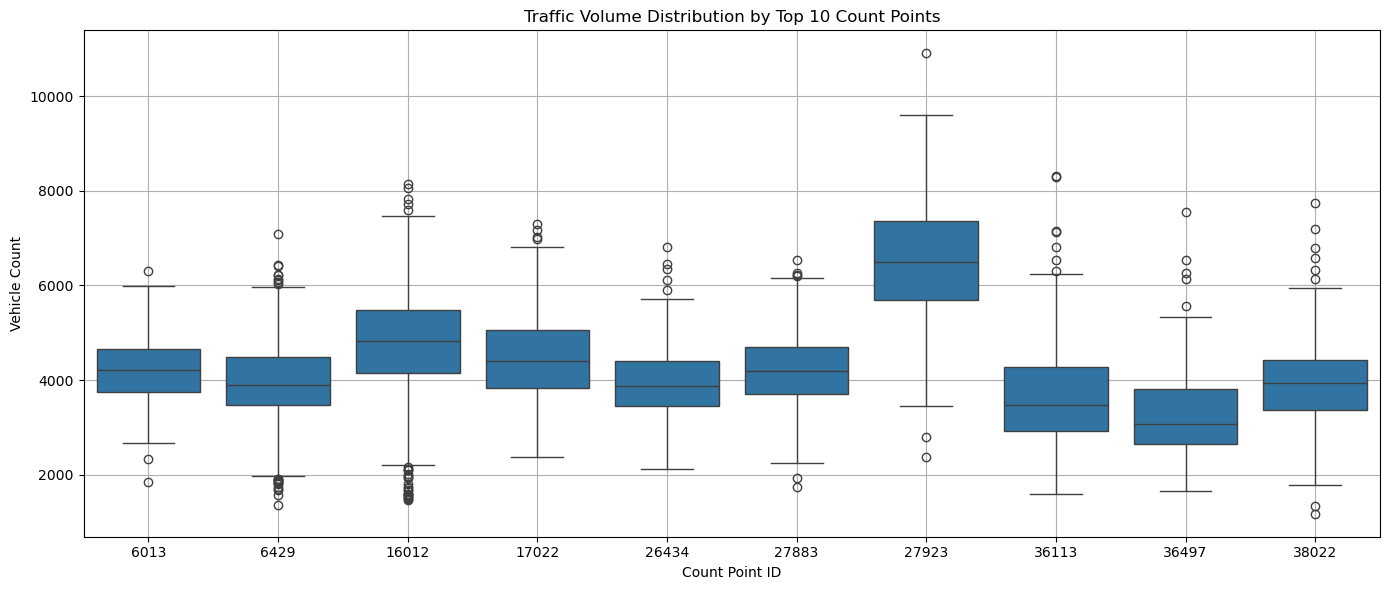

In [109]:
top_sites = (
    df.groupby("count_point_id")["all_motor_vehicles"]
    .sum()
    .nlargest(10)
    .index
)

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df[df["count_point_id"].isin(top_sites)],
    x="count_point_id",
    y="all_motor_vehicles"
)
plt.title("Traffic Volume Distribution by Top 10 Count Points")
plt.xlabel("Count Point ID")
plt.ylabel("Vehicle Count")
plt.grid(True)
plt.tight_layout()
plt.show()
